- generate data
- train rf
- create pdp, and determine monotonic relations

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib_inline.backend_inline import set_matplotlib_formats
from sklearn.datasets import make_friedman1
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

In [2]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# setting global plotting settings
# roudning all floats to two digits
pd.options.display.float_format = "{:.2f}".format

set_matplotlib_formats("svg")
sns.set_context(context="notebook", font_scale=1.5)
sns.set_palette("tab10")
sns.set_style("darkgrid")
FIGSIZE = (12, 6)
RANDOM_STATE = 35

## Intro

Today, we're examining partial dependence plots, a tool for visualizing the average influence of a feature on a model's predictions.

#TODO why would we want to see a partial dependece plot

To demonstrate this, we'll utilize a dataset from Scikit-learn, which can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_friedman1.html#sklearn.datasets.make_friedman1).

The formula generating the synthetic dataset is as follows: 
$y(X) = 10\sin(\pi \cdot X_0 \cdot X_1) + 20 \cdot (X_2 - 0.5)^2 + 10 \cdot X_3 + 5 \cdot X_4 + \text{noise} \cdot N(0, 1)$. 

I will generate a dataset comprising 7 features, but only 5 will actually influence the output—meaning the remaining two have no predictive value.
the generate dataset contains 2000 samples and has a noise factor of 2.


In [25]:
# | code-fold: show

X_reg, y_reg = make_friedman1(
    n_samples=2_000, n_features=7, noise=2, random_state=RANDOM_STATE
)

# stick it into a dataframe
df_reg = pd.concat(
    [
        pd.DataFrame(
            data=X_reg, columns=["x_0", "x_1", "x_2", "x_3", "x_4", "x_5", "x_6"]
        ),
        pd.DataFrame(data=y_reg, columns=["target"]),
    ],
    axis=1,
)

# display descriptive stats
df_reg.describe().T

,count,mean,std,min,25%,50%,75%,max
x_0,2000.00,0.49,0.29,0.00,0.25,0.49,0.74,1.00
x_1,2000.00,0.50,0.29,0.00,0.25,0.51,0.76,1.00
x_2,2000.00,0.50,0.29,0.00,0.25,0.52,0.75,1.00
x_3,2000.00,0.50,0.28,0.00,0.26,0.51,0.75,1.00
x_4,2000.00,0.50,0.29,0.00,0.25,0.50,0.75,1.00
x_5,2000.00,0.50,0.29,0.00,0.24,0.49,0.75,1.00
x_6,2000.00,0.50,0.28,0.00,0.26,0.51,0.75,1.00
target,2000.00,14.48,5.26,-1.56,10.72,14.46,18.15,30.51


all input features are uniform distributed $U(0,1)$ -> the mean is ~0.5 
the target feature has a higher mean of ~14 

The data is fed into a random-forest model, [it is my favorite go to model](https://www.linkedin.com/feed/update/urn:li:activity:7169278449243607041?updateEntityUrn=urn%3Ali%3Afs_feedUpdate%3A%28V2%2Curn%3Ali%3Aactivity%3A7169278449243607041%29), no feature scaling required can handle missing values, can capture non-linearity, has ability to model non-linearity, and fitting can be quite fast.

In [5]:
# | code-fold: show
X = df_reg.drop(columns="target")
y = df_reg["target"]

reg = RandomForestRegressor(
    n_estimators=32,
    max_depth=9,
    min_samples_split=2,
    random_state=42,
)
_ = reg.fit(X, y)

to determine the partial dependence (PD) of each feature on the target we need to do some dataset wrangling.
lets start with a (very very small) subset of our data taken at random.

In [6]:
# | code-fold: show

df_sample = df_reg.sample(3, random_state=1)
df_sample

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,target
674,0.36,0.70,0.83,0.03,0.26,0.53,0.61,12.79
1699,0.32,0.70,0.38,0.02,0.38,0.40,0.14,8.29
1282,0.31,0.21,0.66,0.40,0.27,0.11,0.84,7.57


## how to calculate the PDP
In order to calculate the PD of lets say `x_0` we would need to follow these steps:
1. determine the range of `x_0`
2. set a grid size, i.e the sampling ratio over the range
3. apply the grid over the data, this will increase the data size by a lot 
4. predict with the model using the newly created dataset
5. average out the individual predictions to get a singular result


1. range of `x_0` is between 0 and 1 
2. lets use a grid size of 7, that means that we create a list of 7 equaly space values between 0 and 1 
3. for each sample in our dataset we apply the grid of 7 values which means that if we have 3 datapoints to begin we end up with 3*7=21 datapoints. that is an increase in data and for bigger data sets and finer grids this increases very fast
4. now we ask the model to make predictions, this is inference and not training so the computational cost is reasonable
5. perform a group by on the sampled grid and apply a average aggregation function
6. the result is the partial dependence of `x_0` and the target variable


### determine the range of `x_0`

In [7]:
# | code-fold: show
df_reg["x_0"].agg(["min", "max"])

min   0.00
max   1.00
Name: x_0, dtype: float64

the range of `x_0` is between zero and one, in this case we are taking the entire region but you could also restrict it to the 90% percentile. 

### set a grid size, i.e the sampling ratio over the range

In this case a rather small grid size of 7 is chosen. that means over the range of 0 to 1 we select 7 equaly spaced datapoints


### apply the grid over the data

by utilizing the `np.linspace()` function we can easily create the grid, and create the required dataset with a cross join. for the people that know cross joins blow up your data pretty fast as it scales quadraticly. so our initial 3 datapoints together with the grid size increase the data count to $ 3 * 7 = 21 $
the newly created column is the feature for which we want to calculate the pd, in this case `x_0_sample`

In [8]:
# | code-fold: show
df_pdp = df_sample.drop(columns="x_0")
df_sample_grid = pd.Series(np.linspace(0, 1, 7), name="x_0_sample").round(2)
df_pdp = df_pdp.join(other=df_sample_grid, how="cross")
df_pdp

,x_1,x_2,x_3,x_4,x_5,x_6,target,x_0_sample
0,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.00
1,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.17
2,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.33
3,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.50
4,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.67
5,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.83
6,0.70,0.83,0.03,0.26,0.53,0.61,12.79,1.00
7,0.70,0.38,0.02,0.38,0.40,0.14,8.29,0.00
8,0.70,0.38,0.02,0.38,0.40,0.14,8.29,0.17
9,0.70,0.38,0.02,0.38,0.40,0.14,8.29,0.33


### predict with the model

for our new dataset we ask the model to make a prediction for each observations, so the original model is asked to create a predictions for each of the newly created 21 data points.

In [9]:
# | code-fold: show
df_pdp = df_pdp.assign(
    y_pred=reg.predict(
        df_pdp.loc[
            :, ["x_0_sample", "x_1", "x_2", "x_3", "x_4", "x_5", "x_6"]
        ].to_numpy()
    )
)
df_pdp

,x_1,x_2,x_3,x_4,x_5,x_6,target,x_0_sample,y_pred
0,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.00,5.23
1,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.17,9.61
2,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.33,12.19
3,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.50,12.58
4,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.67,12.72
5,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.83,12.66
6,0.70,0.83,0.03,0.26,0.53,0.61,12.79,1.00,12.79
7,0.70,0.38,0.02,0.38,0.40,0.14,8.29,0.00,5.76
8,0.70,0.38,0.02,0.38,0.40,0.14,8.29,0.17,9.31
9,0.70,0.38,0.02,0.38,0.40,0.14,8.29,0.33,9.89


### average out the individual predictions

the next step is the aggregate the results by taking the average.
this is achieved by taking the columns `x_0_sample` , `y_pred` and grouping by `x_0_sample` and applying mean aggregation.

In [10]:
# | code-fold: show
df_pdp_plot = (
    df_pdp[["x_0_sample", "y_pred"]].groupby("x_0_sample", as_index=False).mean()
)
df_pdp_plot

,x_0_sample,y_pred
0,0.00,5.88
1,0.17,8.63
2,0.33,9.94
3,0.50,11.01
4,0.67,11.43
5,0.83,11.70
6,1.00,11.82


this is the dataframe that shows the average dependence of the target variable with respect to the feature `x_0` in this case. increasing the value of `x_0` also yields an increase of the target variable. as can be seen in the plot below. however keep in mind that this is done with a subset of the data on a very coarse grid. 
if more  samples are included and the size of the grid is increased a more detailed dependence will emerge.

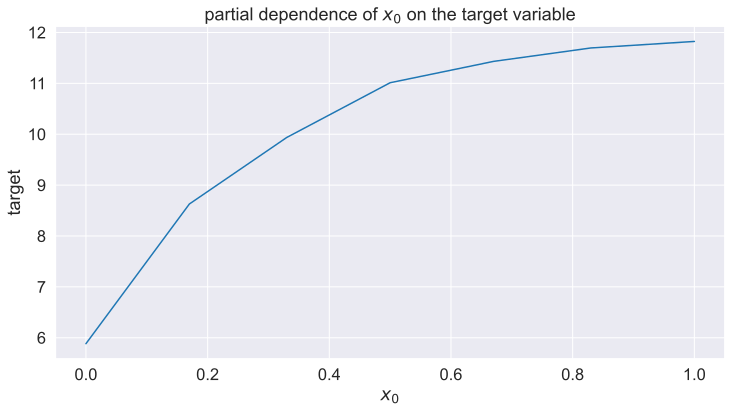

In [11]:
_, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.plot(df_pdp_plot["x_0_sample"], df_pdp_plot["y_pred"])
ax.set_xlabel("$x_0$")
ax.set_ylabel("target")
ax.set_title("partial dependence of $x_0$ on the target variable")
plt.show()

the plot above shows that the response of the model is postive with respect to an increase in the value of feature `x_0` however this is done with just three datapoints,If we use the full dataset of 2000 samples and a sampling grid of 127 that would result in a final dataset of $2000 * 128 = 256.000$ samples. yikes that explodes fast and this is just for one feature. however we do have the ability to get a more accurate picture of the partial dependece of the `x_0` variable.

below you can see the code, i placed two comments to indicate where the changes have been made.

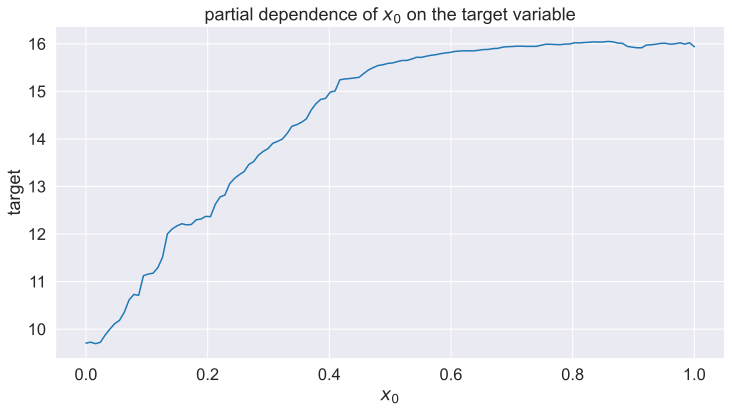

In [12]:
# | code-fold: show
df_pdp = df_reg.drop(columns="x_0")  # <- the full dataset
df_sample_grid = pd.Series(
    np.linspace(0, 1, 128),  # <- sampling is 128
    name="x_0_sample",
)
df_pdp = df_pdp.join(other=df_sample_grid, how="cross")

df_pdp = df_pdp.assign(
    y_pred=reg.predict(
        df_pdp.loc[
            :, ["x_0_sample", "x_1", "x_2", "x_3", "x_4", "x_5", "x_6"]
        ].to_numpy()
    )
)

df_pdp_plot_full = (
    df_pdp[["x_0_sample", "y_pred"]].groupby("x_0_sample", as_index=False).mean()
)

_, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.plot(df_pdp_plot_full["x_0_sample"], df_pdp_plot_full["y_pred"])
ax.set_xlabel("$x_0$")
ax.set_ylabel("target")
ax.set_title("partial dependence of $x_0$ on the target variable")
plt.show()

the same picture as before emerges however this time it includes a little more detail, an increaase in `x_0` also yields an increase in the target variable to an almost monotonic level. 

## Scikit-learn implementation

in practise we would not code our own PDP routinge but first look if there already is a lib that does the job and  scikit-learn  has an implementation of a [partial dependence](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.partial_dependence.html#sklearn.inspection.partial_dependence) and also the [SHAP](https://shap.readthedocs.io/en/latest/generated/shap.plots.partial_dependence.html) packages has a PDP option, super handy if you are already using it to get shapley values.

### one-way partial dependence

by using the scikit-learn function we can easily create plots for our entire dataset. it is just with a one-liner 😊.
 


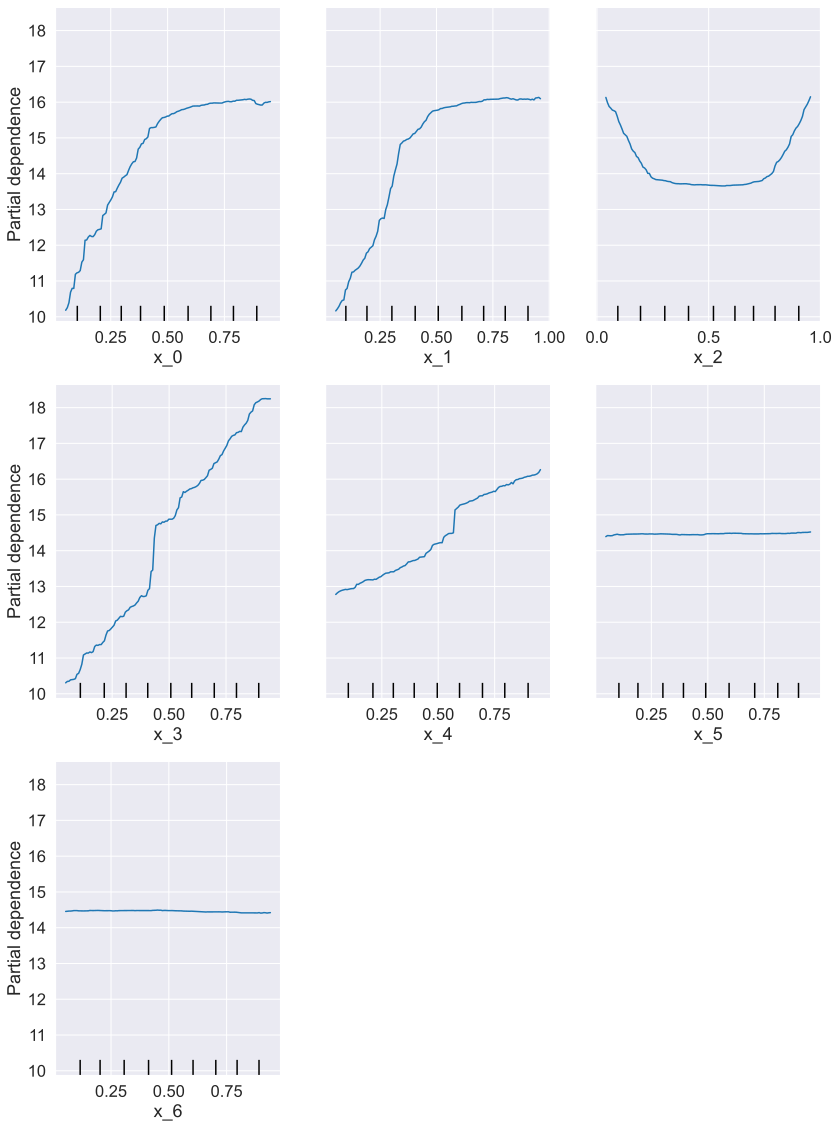

In [13]:
# | cold-fold:show

_, ax = plt.subplots(1, 1, figsize=(12, 16))

PartialDependenceDisplay.from_estimator(
    estimator=reg, X=X, features=range(0, 7), grid_resolution=128, kind="average", ax=ax
)
plt.tight_layout()
plt.show()

for the plot above we can clearly see that `x_6` and `x_5` do not meaningfully contribute to the output of the model. so changes one of those two will not change the predicted target value. this is also logical because these two features are random noise. `x_2` has the shape of a bathtub and the mean of 0.5 yields the lowest target outcome. `x_0` and  `x_1` show a steady monotonic increase and plateau for the higher input values, after which the impact on the target is diminished. for the remaining two features `x_3` and `x_4` show that an increase in the feature yields a higher outcome of the target, also a big jump in output can be seen at around 0.4 for `x_3` adn 0.6 for `x_4`


### two-way partial dependence

It is possible to adapt this approach and get the PDP of two features with respect to the target variable. the trick is to create a sample grid that is the product of the two features. but again this will increase the number of datapoints that need to be inferenced. however now you can obtain insights into the feature interactions and the results it has on the target variable.

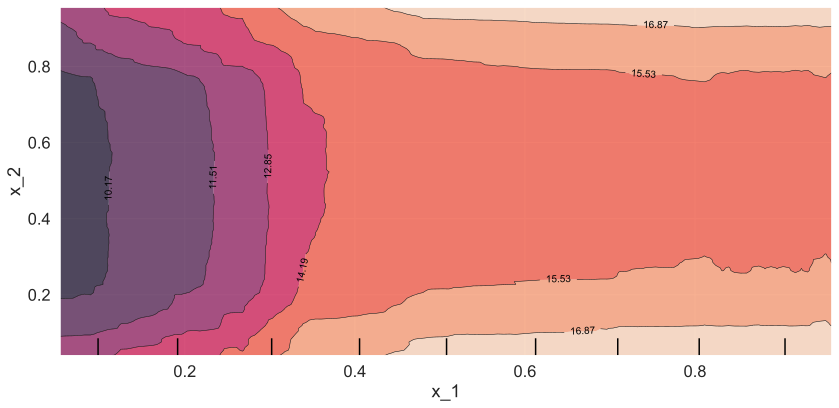

In [14]:
# |code-fold:show
_, ax = plt.subplots(1, 1, figsize=FIGSIZE)

PartialDependenceDisplay.from_estimator(
    reg, X, features=[(1, 2)], grid_resolution=128, ax=ax
)
plt.tight_layout()
plt.show()

## Bonus: Individual Conditional Expectation
instead of performing a aggregation and plotting the result, theinndividual observations can alos be used. in the plot each blue line is an original observation were the value of `x_3` has taken over by the sampling grid. this allows you to inspect the individual datapoints. in this case we have a well beheaved dataset were all points are in agreement however this plot might give you some insights if performance is lacking for a couple of datapoints. it well may be that if the feature values is increased the target value goes up for one group and goes down for another group.

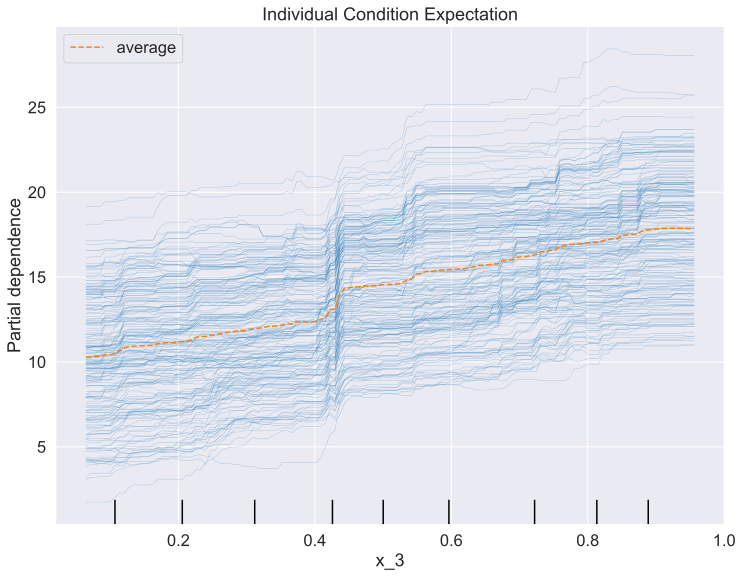

In [15]:
# |code-fold:false
_, ax = plt.subplots(1, 1, figsize=(12, 9))

idx = np.random.randint(len(X), size=int(len(X) * 0.1), dtype=int)


PartialDependenceDisplay.from_estimator(
    reg, X.loc[idx, :], features=[3], kind="both", grid_resolution=128, ax=ax
)
ax.set_title("Individual Condition Expectation")
plt.show()

In [16]:
### gif

In [17]:
import gif  # noqa E402

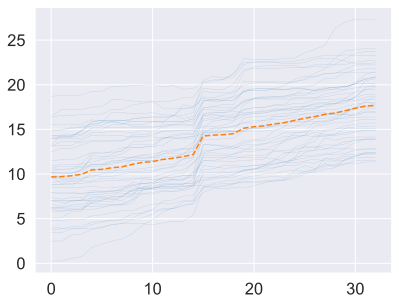

In [18]:
idx = np.random.randint(len(X), size=int(len(X) * 0.025), dtype=int)


pdp_results = partial_dependence(
    estimator=reg,
    X=X.loc[idx, :],
    features=["x_3"],
    grid_resolution=33,
    kind="both",
)

plt.plot(
    pdp_results["individual"][0].T,
    linestyle="-",
    linewidth=0.25,
    alpha=0.33,
    color="tab:blue",
)
plt.plot(
    np.mean(pdp_results["individual"][0].T, axis=1), linestyle="--", color="tab:orange"
);

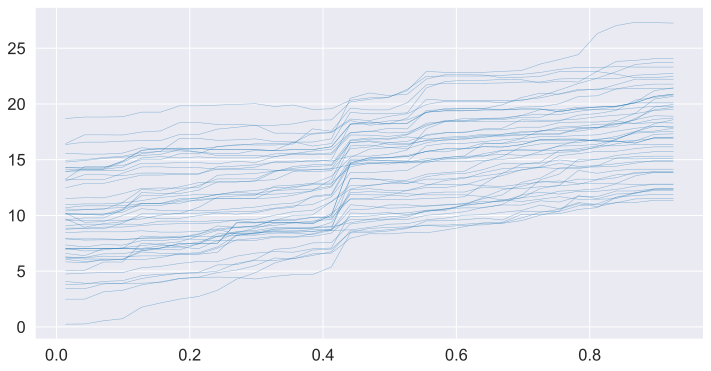

In [19]:
individual_lines = pdp_results["individual"][0].T


_, ax = plt.subplots(1, 1, figsize=FIGSIZE)


ax.plot(
    pdp_results["grid_values"][0],
    individual_lines[:, 0],
    linestyle="-",
    linewidth=0.5,
    alpha=0.5,
    color="tab:blue",
)


xlim_begin, ylim_begin = ax.get_xlim(), ax.get_ylim()


ax.plot(
    pdp_results["grid_values"][0],
    individual_lines[:, :],
    linestyle="-",
    linewidth=0.5,
    alpha=0.5,
    color="tab:blue",
)

xlim_end, ylim_end = ax.get_xlim(), ax.get_ylim()

zoom_factor = 0
# get the global axes limits
overal_xlim = (
    min(xlim_begin[0], xlim_end[0]) * (1 - zoom_factor),
    max(xlim_begin[1], xlim_end[1]) * (1 + zoom_factor),
)
overal_ylim = (
    min(ylim_begin[0], ylim_end[0]) * (1 - zoom_factor),
    max(ylim_begin[1], ylim_end[1]) * (1 + zoom_factor),
)

In [20]:
# for i in range(individual_lines.shape[1])


@gif.frame
def one_frame(i: int, overal_xlim=None, overal_ylim=None) -> None:
    _, ax = plt.subplots(1, 1, figsize=FIGSIZE)

    ax.plot(
        pdp_results["grid_values"][0],
        individual_lines[:, :i],
        linestyle="-",
        linewidth=0.75,
        alpha=0.35,
        color="tab:blue",
    )

    if i > 1:
        ax.plot(
            pdp_results["grid_values"][0],
            np.mean(individual_lines[:, :i], axis=1),
            linestyle="--",
            linewidth=3,
            color="tab:orange",
        )

    # set the overal axes
    ax.set_xlim(overal_xlim), ax.set_ylim(overal_ylim)

    # remove the ticks and lables from the axes
    xticks = ax.get_xticks()
    ax.set_xticks(xticks, labels=[])
    ax.set_xlabel("")

    yticks = ax.get_yticks()
    ax.set_yticks(yticks, labels=[])
    ax.set_ylabel("")

    plt.tight_layout()

In [21]:
# genearate all base frames
gif_frames = [
    one_frame(i, overal_xlim, overal_ylim) for i in range(individual_lines.shape[1])
]

In [22]:
# add bounce and freeze point
gif_frames.extend([gif_frames[-1] for _ in range(60)])
gif_frames.extend(gif_frames[::-1])

In [23]:
gif.save(gif_frames, "artifacts/ice_lines.gif", duration=1)